# Proyecto 1
<h3>Natalia Ortega (sección 4), David Leon (sección 3) & Juan Camilo Mercado (sección 4)</h3>

## 0. Carga de librerías y datos

In [356]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn as sklearn
import nltk
import random
import statistics
import string
import unicodedata

from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from scipy import stats as st
from nltk.probability import *
from nltk.tokenize import word_tokenize
from sklearn import preprocessing

# Para preparar los datos
from sklearn.preprocessing import LabelEncoder
# Para crear el arbol de decisión 
from sklearn.tree import DecisionTreeClassifier 
# Para usar KNN como clasificador
from sklearn.neighbors import KNeighborsClassifier
# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test.
from sklearn.model_selection import train_test_split
# Para evaluar el modelo
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

# Versiones anteriores a 1.2 de sklearn: from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold 
#Librerías para la visualización
from sklearn import tree


In [357]:
nltk.download('punkt');
nltk.download('stopwords');
nltk.download('wordnet');

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CAMILO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CAMILO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CAMILO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [358]:
df = pd.read_csv('./data/tipo2_entrenamiento_estudiantes.csv', sep=',', encoding = 'utf-8')

## 1. Entendimiento y preparación de datos

### Entendimiento

In [359]:
print(f">> Se puede observar que el df de entrenamiento contiene {df.shape[0]} reseñas")

>> Se puede observar que el df de entrenamiento contiene 7875 reseñas


In [360]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7875 entries, 0 to 7874
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  7875 non-null   object
 1   Class   7875 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 123.2+ KB


In [361]:
print(">> El df se ve de la siguiente forma:")
df.head()

>> El df se ve de la siguiente forma:


,Review,Class
0,Muy buena atención y aclaración de dudas por p...,5
1,Buen hotel si están obligados a estar cerca de...,3
2,"Es un lugar muy lindo para fotografías, visite...",5
3,Abusados con la factura de alimentos siempre s...,3
4,Tuvimos un par de personas en el grupo que rea...,3


In [362]:
textos = df.copy()
textos['Conteo'] = [len(x) for x in textos['Review']]
textos['Palabras únicas'] = [len(set(x)) for x in textos['Review']]
textos['Max. de palabra'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Review']]
textos['Min. de palabra'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Review']]
textos['Moda'] = [statistics.mode(i.split(' ')) for i in textos['Review']]

textos

,Review,Class,Conteo,Palabras únicas,Max. de palabra,Min. de palabra,Moda
0,Muy buena atención y aclaración de dudas por p...,5,252,28,20,0,
1,Buen hotel si están obligados a estar cerca de...,3,297,34,13,1,de
2,"Es un lugar muy lindo para fotografías, visite...",5,104,26,12,1,Es
3,Abusados con la factura de alimentos siempre s...,3,422,28,14,1,y
4,Tuvimos un par de personas en el grupo que rea...,3,419,35,14,1,el
...,...,...,...,...,...,...,...
7870,"Me parece buen sistema, agiliza el transporte,...",4,113,24,11,2,el
7871,"Fue una escapada de un día desde el complejo, ...",4,261,31,12,2,de
7872,La Plaza de la Revolución es un lugar emblemát...,3,777,43,14,1,de
7873,Es la segunda ocasión que me quedo en los cuar...,1,651,38,12,0,que


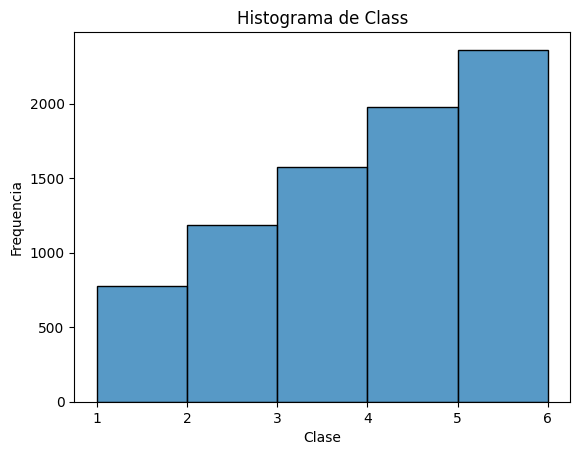

In [363]:
sns.histplot(data=textos, x='Class', bins=range(1, 7), kde=False)
plt.xlabel('Clase')
plt.ylabel('Frequencia')
plt.title('Histograma de Class')
plt.xticks(range(1, 7))
plt.show()



In [364]:
textos.describe()

,Class,Conteo,Palabras únicas,Max. de palabra,Min. de palabra
count,7875.000000,7875.000000,7875.000000,7875.000000,7875.000000
mean,3.502603,408.050413,33.117714,13.145778,0.858413
std,1.320435,474.145795,7.896652,2.930502,0.515585
min,1.000000,9.000000,9.000000,4.000000,0.000000
25%,3.000000,196.000000,28.000000,11.000000,1.000000
50%,4.000000,269.000000,31.000000,13.000000,1.000000
75%,5.000000,488.000000,37.000000,14.000000,1.000000
max,5.000000,10403.000000,80.000000,76.000000,5.000000


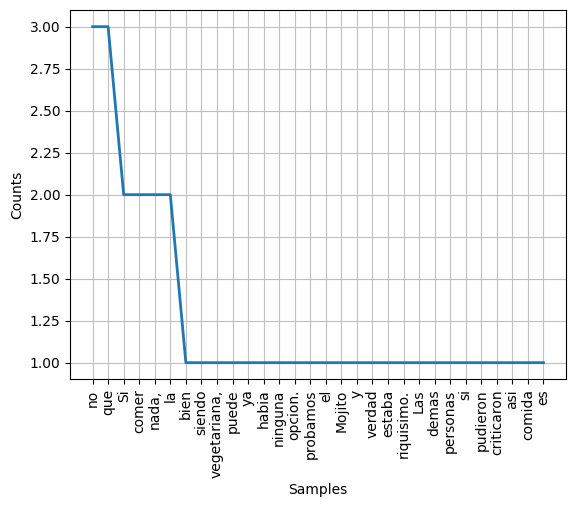

<Axes: xlabel='Samples', ylabel='Counts'>

In [365]:
fdist = FreqDist(df['Review'][random.randint(0, df.shape[0])].split(' '))
fdist.plot(30, cumulative = False)

### Segmentación de palabras (tokenización)

In [366]:

token_df = df.copy()
token_df['Words'] = df['Review'].apply(word_tokenize)
token_df.head()

,Review,Class,Words
0,Muy buena atención y aclaración de dudas por p...,5,"[Muy, buena, atención, y, aclaración, de, duda..."
1,Buen hotel si están obligados a estar cerca de...,3,"[Buen, hotel, si, están, obligados, a, estar, ..."
2,"Es un lugar muy lindo para fotografías, visite...",5,"[Es, un, lugar, muy, lindo, para, fotografías,..."
3,Abusados con la factura de alimentos siempre s...,3,"[Abusados, con, la, factura, de, alimentos, si..."
4,Tuvimos un par de personas en el grupo que rea...,3,"[Tuvimos, un, par, de, personas, en, el, grupo..."


### Limpieza de datos (StopWords) y análisis lexicográfico

In [367]:
class TextProcessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('spanish'))
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = SnowballStemmer('spanish')
        self.punctuation = string.punctuation

    def to_lowercase(self, texto):
        return [word.lower() for word in texto]

    def remove_punctuation(self, texto):
        return [word for word in texto if word not in self.punctuation]

    def remove_stopwords(self, texto):
        return [word for word in texto if word not in self.stop_words]

    def lemmatize(self, texto):
        return [self.lemmatizer.lemmatize(word) for word in texto]

    def stem(self, texto):
        return [self.stemmer.stem(word) for word in texto]

    def remove_non_ascii(self, texto):
        return [unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in texto]

    def preprocess(self, texto):
        texto = self.to_lowercase(texto)
        texto = self.remove_punctuation(texto)
        texto = self.remove_stopwords(texto)
        texto = self.lemmatize(texto)
        texto = self.stem(texto)
        texto = self.remove_non_ascii(texto)
        return texto

In [368]:
processor = TextProcessor()
token_df['Stemmed words'] = [processor.preprocess(text) for text in token_df['Words']]
token_df.head()

,Review,Class,Words,Stemmed words
0,Muy buena atención y aclaración de dudas por p...,5,"[Muy, buena, atención, y, aclaración, de, duda...","[buen, atencion, aclar, dud, part, senorit, ve..."
1,Buen hotel si están obligados a estar cerca de...,3,"[Buen, hotel, si, están, obligados, a, estar, ...","[buen, hotel, si, oblig, cerc, centr, convenci..."
2,"Es un lugar muy lindo para fotografías, visite...",5,"[Es, un, lugar, muy, lindo, para, fotografías,...","[lug, lind, fotograf, visit, selin, music, viv..."
3,Abusados con la factura de alimentos siempre s...,3,"[Abusados, con, la, factura, de, alimentos, si...","[abus, factur, aliment, siempr, echan, culp, v..."
4,Tuvimos un par de personas en el grupo que rea...,3,"[Tuvimos, un, par, de, personas, en, el, grupo...","[par, person, grup, realment, quer, com, cabri..."


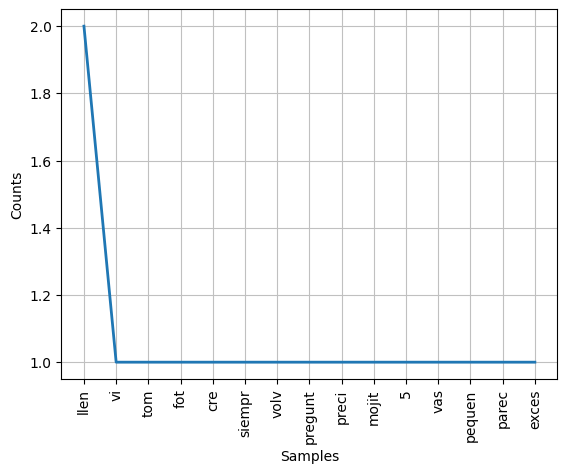

<Axes: xlabel='Samples', ylabel='Counts'>

In [369]:
fdist = FreqDist(token_df['Stemmed words'][random.randint(0, df.shape[0])])
fdist.plot(30, cumulative = False)

### Vectorización de texto

In [370]:
def cleaning(text):
    processor = TextProcessor()
    return [processor.preprocess(text_token) for text_token in word_tokenize(text)]
    

In [374]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Obtén los datos de entrenamiento y las etiquetas
X = token_df['Text']
y = token_df['Class']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

# Crear el vectorizador BOW
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Crear el clasificador Naive Bayes
classifier = SVC()

# Entrenar el clasificador
classifier.fit(X_train_bow, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = classifier.predict(X_test_bow)

# Calcular la precisión del clasificador
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del clasificador: {:.2f}%".format(accuracy * 100))


Precisión del clasificador: 48.25%


In [375]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Crear el vectorizador TF-IDF
vectorizer = TfidfVectorizer()

# Vectorizar los datos de texto
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Crear el modelo de clasificación (por ejemplo, un SVM)
model = SVC()

# Entrenar el modelo
model.fit(X_train_tfidf, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test_tfidf)

# Obtener el informe de clasificación
report = classification_report(y_test, y_pred)
print(report)

# Calcular la precisión del clasificador
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del clasificador: {:.2f}%".format(accuracy * 100))


              precision    recall  f1-score   support

           1       0.60      0.23      0.34       138
           2       0.47      0.38      0.42       244
           3       0.41      0.44      0.42       314
           4       0.47      0.41      0.43       424
           5       0.56      0.76      0.65       455

    accuracy                           0.50      1575
   macro avg       0.50      0.44      0.45      1575
weighted avg       0.49      0.50      0.48      1575

Precisión del clasificador: 49.59%


In [376]:
import numpy as np
from sklearn.svm import SVC
from gensim.models import Word2Vec

# Entrenar el modelo de Word2Vec
sentences = [text.split() for text in token_df['Text']]
word2vec_model = Word2Vec(sentences, vector_size=3, window=2, min_count=1)

# Obtener los vectores de palabras para cada texto
X = []
for text in sentences:
    vector = np.zeros(3)  # Tamaño del vector de palabras
    for word in text:
        if word in word2vec_model.wv:
            vector += word2vec_model.wv[word]
    X.append(vector)

# Convertir la lista de vectores en una matriz numpy
X = np.array(X)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, df['Class'], test_size=0.2, random_state=42)

# Crear y entrenar el modelo SVC
model = SVC()
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Obtener el informe de clasificación
report = classification_report(y_test, y_pred)
print(report)

# Calcular la precisión del clasificador
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del clasificador: {:.2f}%".format(accuracy * 100))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00       161
           2       0.35      0.34      0.34       227
           3       0.24      0.13      0.17       299
           4       0.34      0.13      0.19       401
           5       0.38      0.82      0.52       487

    accuracy                           0.36      1575
   macro avg       0.26      0.28      0.24      1575
weighted avg       0.30      0.36      0.29      1575

Precisión del clasificador: 35.94%


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
